Visualizes results from mlflow.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import sys

import elegy as eg
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mlflow

jnp.arange(0)  # Prints out any jax warnings.

DeviceArray([], dtype=int32)

In [3]:
sys.path.append("..")

import src.utils as utils
utils.mlflow_init()

### Load experiment data

In [4]:
@dataclasses.dataclass
class RunResult:
    run_id: str
    
    run: mlflow.entities.run.Run = dataclasses.field(init=False)
    hists: dict[int, list[dict]] = dataclasses.field(init=False)
    
    ns: jnp.ndarray = dataclasses.field(init=False)
    train_mses: jnp.ndarray = dataclasses.field(init=False)
    val_mses: jnp.ndarray = dataclasses.field(init=False)
    epochs: jnp.ndarray = dataclasses.field(init=False)
    
    def __post_init__(self):
        self.run = mlflow.get_run(self.run_id)
        self.hists = utils.mlflow_read_jax(
            run_id=self.run_id,
            rel_artifact_path="histories.bin"
        )
        
        self.ns = jnp.array(list(self.hists.keys()))
        self.train_mses = jnp.array([
            [h['mean_squared_error_loss'][-1] for h in hs]
            for hs in self.hists.values()
        ])
        self.val_mses = jnp.array([
            [h['val_mean_squared_error_loss'][-1] for h in hs]
            for hs in self.hists.values()
        ])
        
        self.epochs = jnp.array([
            [len(h['loss']) for h in hs]
            for hs in self.hists.values()
        ])

In [5]:
RUN_IDS = ["601d5253759e40ecba4761c6600b9096", "054f084eadec4cbdbe2b6361b51d96cf"]
RUNS = {rid : RunResult(rid) for rid in RUN_IDS}

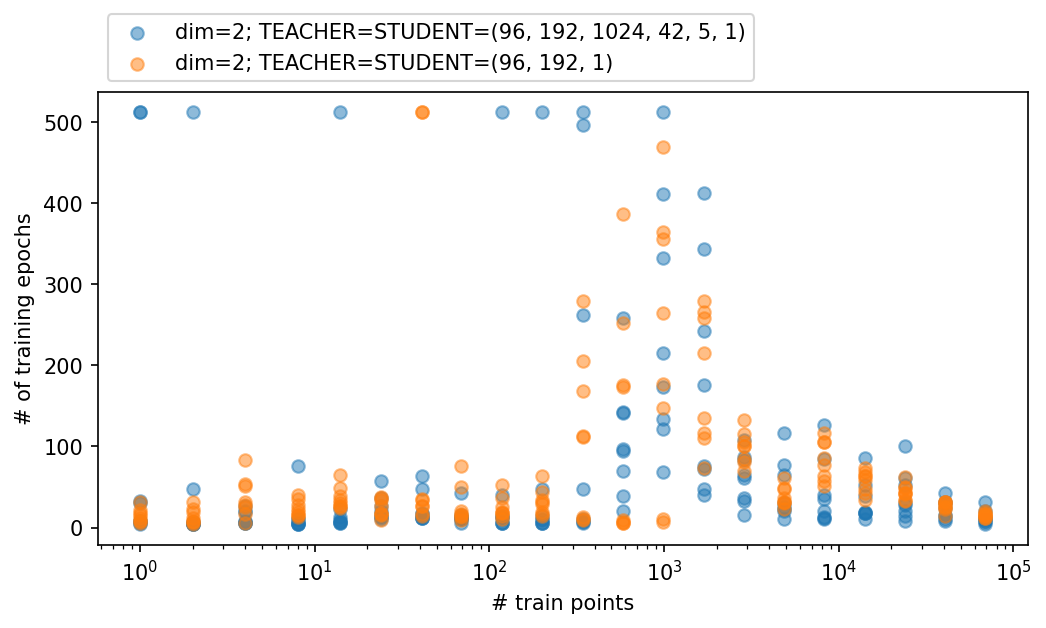

In [6]:
plt.figure(figsize=(8, 4), dpi=150)
for run in RUNS.values():
    
    plt.scatter(
        x=jnp.stack([run.ns for _ in range(8)]).T.flatten(),
        y=run.epochs,
        label=f"dim={run.run.data.params['input_dim']}; "
            + f"TEACHER=STUDENT={run.run.data.params['layer_widths']}",
        alpha=0.5
    )

plt.xscale("log")
plt.xlabel("# train points")
plt.ylabel("# of training epochs");
plt.legend(loc="lower left", bbox_to_anchor=(0, 1));

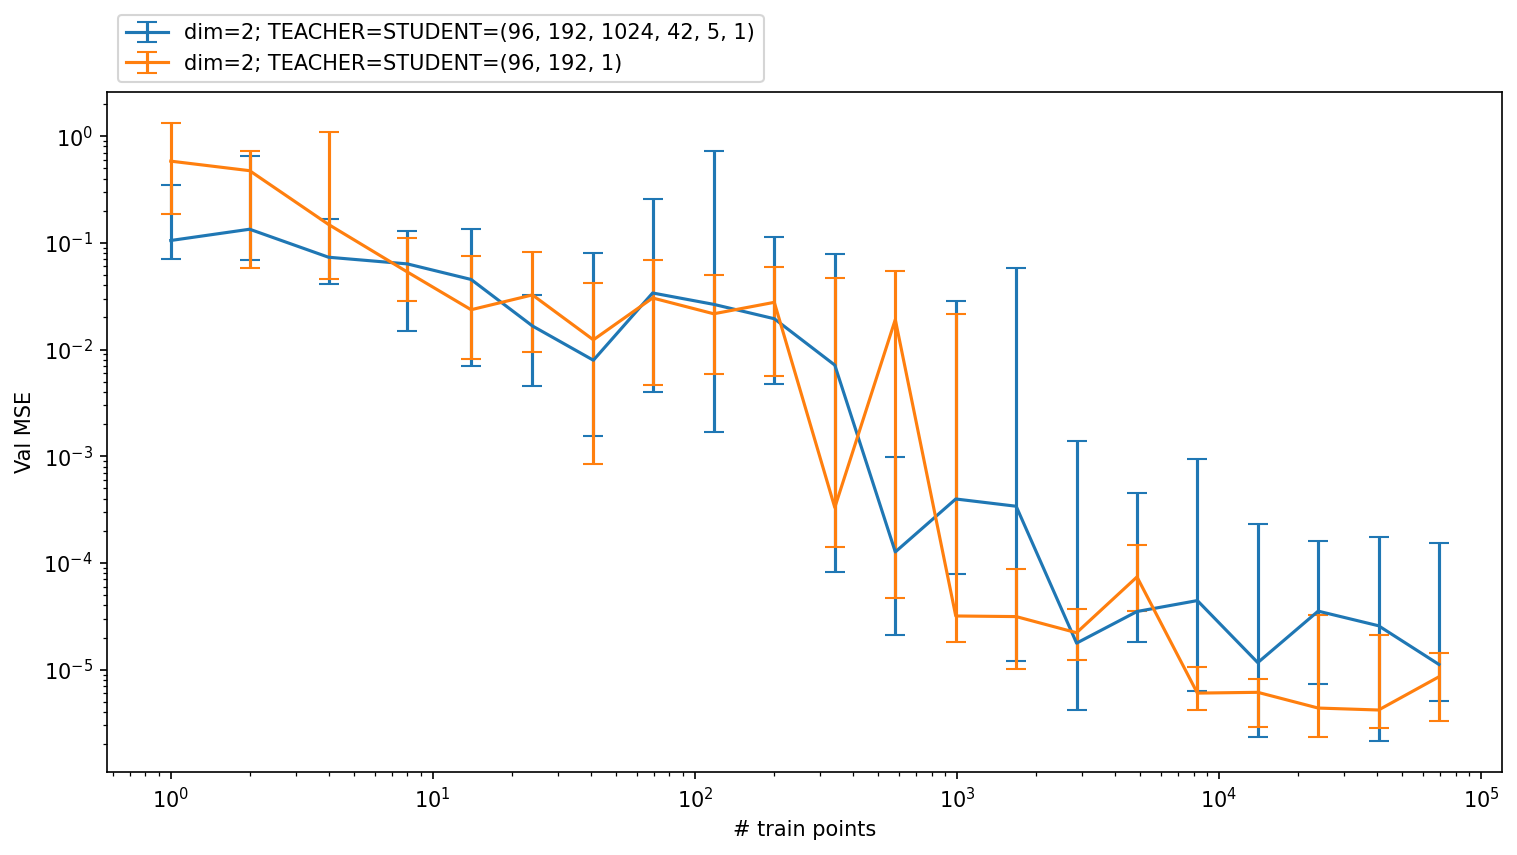

In [7]:
plt.figure(figsize=(12, 6), dpi=150)
for run in RUNS.values():
    med = jnp.quantile(run.val_mses, 0.5, axis=-1)
    lo = jnp.quantile(run.val_mses, 0.05, axis=-1)
    hi = jnp.quantile(run.val_mses, 0.95, axis=-1)

    plt.errorbar(
        x=run.ns,
        y=med,
        yerr=jnp.stack([med-lo, hi-med]),
        capsize=5,
        label=f"dim={run.run.data.params['input_dim']}; "
            + f"TEACHER=STUDENT={run.run.data.params['layer_widths']}"
    )

plt.yscale("log"); plt.xscale("log");
plt.xlabel("# train points")
plt.ylabel("Val MSE");
plt.legend(loc="lower left", bbox_to_anchor=(0, 1));

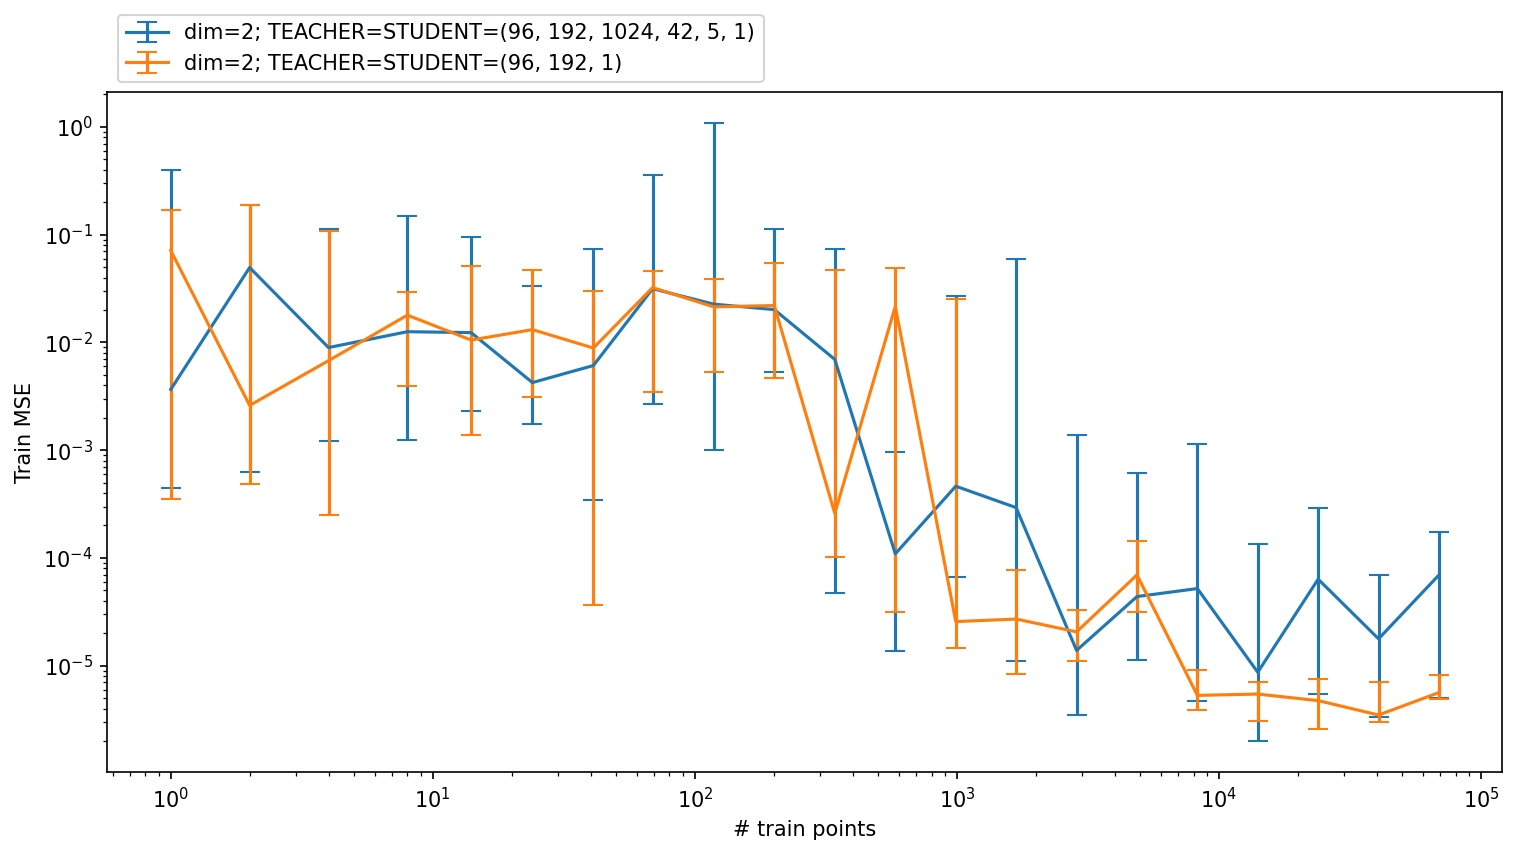

In [8]:
plt.figure(figsize=(12, 6), dpi=150)
for run in RUNS.values():
    med = jnp.quantile(run.train_mses, 0.5, axis=-1)
    lo = jnp.quantile(run.train_mses, 0.05, axis=-1)
    hi = jnp.quantile(run.train_mses, 0.95, axis=-1)

    plt.errorbar(
        x=run.ns,
        y=med,
        yerr=jnp.stack([med-lo, hi-med]),
        capsize=5,
        label=f"dim={run.run.data.params['input_dim']}; "
            + f"TEACHER=STUDENT={run.run.data.params['layer_widths']}"
    )

plt.yscale("log"); plt.xscale("log");
plt.xlabel("# train points")
plt.ylabel("Train MSE");
plt.legend(loc="lower left", bbox_to_anchor=(0, 1));

In [9]:
"""
plt.scatter(ns, train_mses.mean(axis=-1), label="train")
plt.scatter(ns, val_mses.mean(axis=-1), label="val")
plt.yscale("log"); plt.xscale("log");
plt.xlabel("# train points")
plt.ylabel("MSE")
plt.title(
    f"dim={RUN.data.params['input_dim']}; "
  + f"TEACHER=STUDENT={RUN.data.params['layer_widths']}"
)
plt.legend();

plt.scatter(
    jnp.stack([ns for _ in range(8)]).T.flatten(),
    train_mses.flatten(),
)
plt.yscale("log"); plt.xscale("log");
plt.xlabel("# train points")
plt.ylabel("Train MSE");
plt.title(
    f"dim={RUN.data.params['input_dim']}; "
  + f"TEACHER=STUDENT={RUN.data.params['layer_widths']}"
);

plt.scatter(
    jnp.stack([ns for _ in range(8)]).T.flatten(),
    val_mses.flatten(),
)
plt.yscale("log"); plt.xscale("log");
plt.xlabel("# train points")
plt.ylabel("Val MSE");
plt.title(
    f"dim={RUN.data.params['input_dim']}; "
  + f"TEACHER=STUDENT={RUN.data.params['layer_widths']}"
);
""";